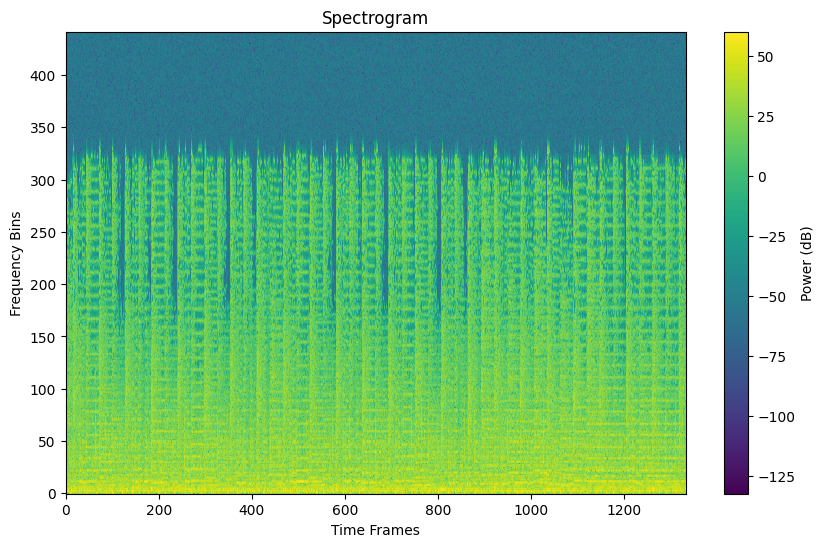

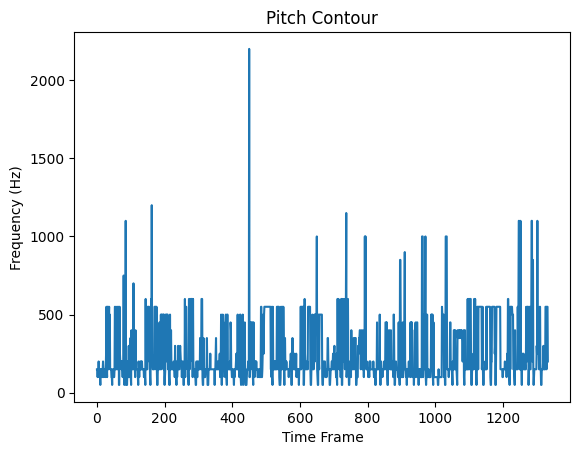

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, spectrogram
from scipy.fftpack import fft

def analyze_audio_fft_spectrogram(signal, fs, frame_size=0.02, overlap=0.1):
    frame_len = int(frame_size * fs)
    hop_size = int(frame_len * (1 - overlap))
    window = np.hanning(frame_len)

    # Compute Spectrogram
    f, t, Sxx = spectrogram(signal, fs, window=window, nperseg=frame_len, noverlap=frame_len - hop_size)
    
    # Initialize results
    pitch_contour = []
    harmonics_list = []
    noise_spectrum = []

    for i in range(len(t)):
        # Extract spectrum for current frame
        spectrum = Sxx[:, i]
        freqs = f

        # Pitch Detection
        peak_idx = np.argmax(spectrum)
        f0 = freqs[peak_idx]
        pitch_contour.append(f0)

        # Harmonics Detection
        harmonics = []
        for n in range(2, 10):  # Check up to 10 harmonics
            harmonic_freq = n * f0
            if harmonic_freq < freqs[-1]:
                harmonic_idx = np.argmin(np.abs(freqs - harmonic_freq))
                if spectrum[harmonic_idx] > 0.1 * spectrum[peak_idx]:  # Threshold for significant harmonics
                    harmonics.append(harmonic_freq)
        harmonics_list.append(harmonics)

        # Noise Estimation
        harmonic_energy = sum([spectrum[np.argmin(np.abs(freqs - h))] for h in harmonics])
        total_energy = sum(spectrum)
        noise_energy = total_energy - harmonic_energy
        noise_spectrum.append(noise_energy)
    
    return pitch_contour, harmonics_list, noise_spectrum, Sxx

# Example Usage
if __name__ == "__main__":
    from scipy.io import wavfile

    # Load an example audio file
    fs, signal = wavfile.read("example.wav")
    if signal.ndim > 1:  # Convert to mono if stereo
        signal = np.mean(signal, axis=1)

    pitch_contour, harmonics_list, noise_spectrum, Sxx = analyze_audio_fft_spectrogram(signal, fs)

    # Plot Spectrogram
    plt.figure(figsize=(10, 6))
    plt.pcolormesh(np.arange(Sxx.shape[1]), np.arange(Sxx.shape[0]), 10 * np.log10(Sxx))
    plt.title("Spectrogram")
    plt.xlabel("Time Frames")
    plt.ylabel("Frequency Bins")
    plt.colorbar(label="Power (dB)")
    plt.show()

    # Plot Pitch Contour
    plt.figure()
    plt.plot(pitch_contour)
    plt.title("Pitch Contour")
    plt.xlabel("Time Frame")
    plt.ylabel("Frequency (Hz)")
    plt.show()


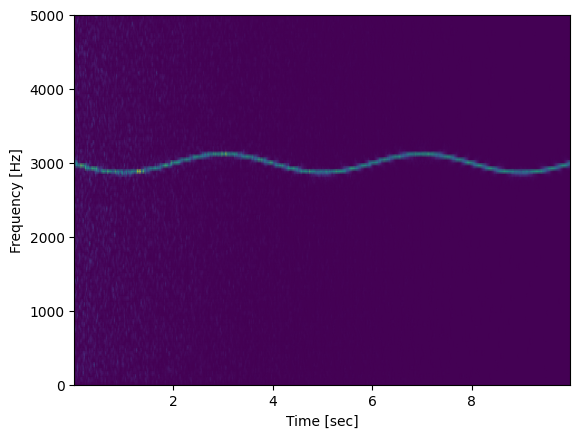

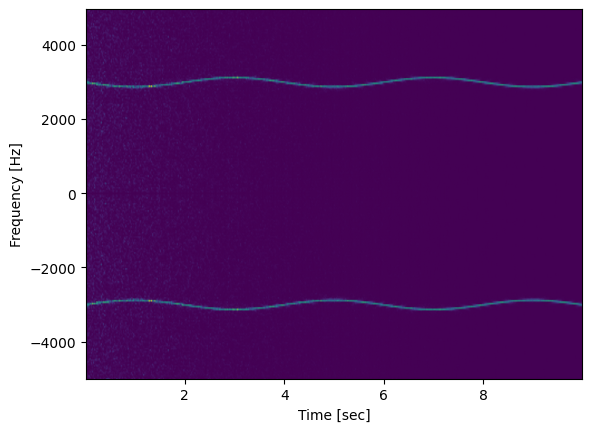

In [12]:
import numpy as np
from scipy import signal
from scipy.fft import fftshift
import matplotlib.pyplot as plt
rng = np.random.default_rng()

fs = 10e3
N = 1e5
amp = 2 * np.sqrt(2)
noise_power = 0.005 * fs / 2
time = np.arange(N) / float(fs)
mod = 500*np.cos(2*np.pi*0.25*time)
carrier = amp * np.sin(2*np.pi*3e3*time + mod)
noise = rng.normal(scale=np.sqrt(noise_power), size=time.shape)
noise *= np.exp(-time/5)
x = carrier + noise

f, t, Sxx = signal.spectrogram(x, fs)
plt.pcolormesh(t, f, Sxx, shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

f, t, Sxx = signal.spectrogram(x, fs, return_onesided=False)
plt.pcolormesh(t, fftshift(f), fftshift(Sxx, axes=0), shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

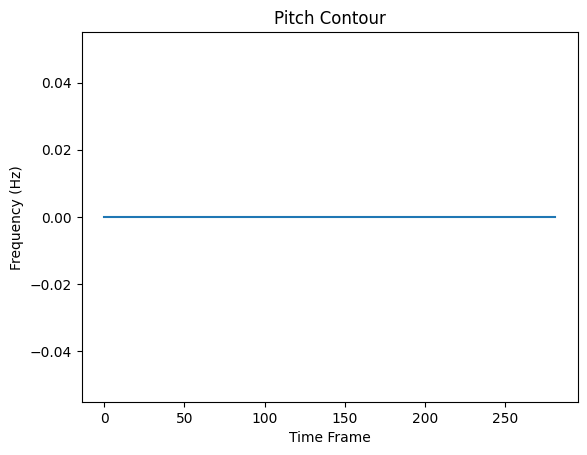

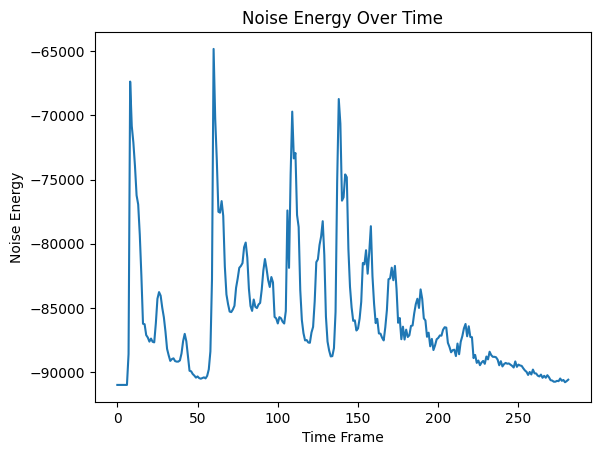

In [10]:
import numpy as np
import matplotlib.pyplot as plt

def manual_dft(signal):
    """
    Manually computes the DFT of a 1D signal.
    """
    N = len(signal)
    dft_result = []
    
    for k in range(N):
        real_part = 0
        imag_part = 0
        for n in range(N):
            angle = -2 * np.pi * k * n / N
            real_part += signal[n] * np.cos(angle)
            imag_part += signal[n] * np.sin(angle)
        dft_result.append(complex(real_part, imag_part))
    
    return np.array(dft_result)

def manual_fft(signal, fs, frame_size=0.02, overlap=0.5):
    """
    Analyze an audio signal using a manually implemented FFT.
    """
    frame_len = int(frame_size * fs)
    hop_size = int(frame_len * (1 - overlap))
    window = np.hanning(frame_len)

    pitch_contour = []
    harmonics_list = []
    noise_energy_list = []
    
    # Iterate through frames
    for start in range(0, len(signal) - frame_len, hop_size):
        frame = signal[start:start+frame_len] * window

        # Manual FFT Implementation
        dft_result = manual_dft(frame)
        magnitude_spectrum = np.abs(dft_result[:frame_len // 2])
        frequencies = np.linspace(0, fs / 2, frame_len // 2)

        # Step 1: Pitch Detection (Fundamental Frequency)
        peak_idx = np.argmax(magnitude_spectrum)
        f0 = frequencies[peak_idx]
        pitch_contour.append(f0)

        # Step 2: Harmonics Detection
        harmonics = []
        for n in range(2, 10):  # Check up to 10 harmonics
            harmonic_freq = n * f0
            if harmonic_freq < frequencies[-1]:
                harmonic_idx = np.argmin(np.abs(frequencies - harmonic_freq))
                if magnitude_spectrum[harmonic_idx] > 0.1 * magnitude_spectrum[peak_idx]:  # Threshold
                    harmonics.append(harmonic_freq)
        harmonics_list.append(harmonics)

        # Step 3: Noise Estimation
        harmonic_energy = sum([magnitude_spectrum[np.argmin(np.abs(frequencies - h))] for h in harmonics])
        total_energy = sum(magnitude_spectrum)
        noise_energy = total_energy - harmonic_energy
        noise_energy_list.append(noise_energy)

    return pitch_contour, harmonics_list, noise_energy_list

# Example Usage
if __name__ == "__main__":
    from scipy.io import wavfile

    # Load an example audio file
    fs, signal = wavfile.read("example2.wav")
    if signal.ndim > 1:  # Convert to mono if stereo
        signal = np.mean(signal, axis=1)

    pitch_contour, harmonics_list, noise_energy_list = manual_fft(signal, fs)

    # Plot Results
    plt.figure()
    plt.plot(pitch_contour)
    plt.title("Pitch Contour")
    plt.xlabel("Time Frame")
    plt.ylabel("Frequency (Hz)")
    plt.show()

    plt.figure()
    plt.plot(noise_energy_list)
    plt.title("Noise Energy Over Time")
    plt.xlabel("Time Frame")
    plt.ylabel("Noise Energy")
    plt.show()


C:\Users\Rj Avro Biswas\AppData\Local\Temp\ipykernel_4592\904990575.py:40: RuntimeWarning: divide by zero encountered in scalar divide
  return geometric_mean / arithmetic_mean
C:\Users\Rj Avro Biswas\AppData\Roaming\Python\Python310\site-packages\matplotlib\axes\_axes.py:8089: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


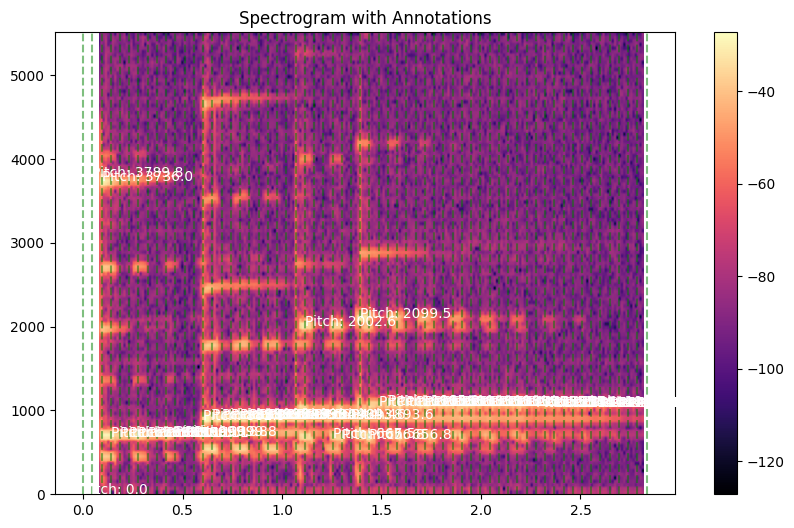

In [8]:
import numpy as np
from scipy.signal import butter, lfilter

def preprocess_audio(audio_signal, sampling_rate, low_freq=50, high_freq=5000):
    # Band-pass filter design
    nyquist = 0.5 * sampling_rate
    low = low_freq / nyquist
    high = high_freq / nyquist
    b, a = butter(4, [low, high], btype='band')
    return lfilter(b, a, audio_signal)


from scipy.signal import stft

def compute_spectrogram(audio_signal, sampling_rate, window_size=1024, overlap=512):
    f, t, Zxx = stft(audio_signal, fs=sampling_rate, nperseg=window_size, noverlap=overlap)
    return f, t, np.abs(Zxx)


def detect_pitch(frequencies, spectrum):
    # Find the peak in the spectrum
    peak_idx = np.argmax(spectrum)
    fundamental_freq = frequencies[peak_idx]
    return fundamental_freq


def find_harmonics(fundamental_freq, frequencies, spectrum, threshold=0.1):
    harmonics = []
    for n in range(2, 10):  # Check first 10 harmonics
        harmonic_freq = n * fundamental_freq
        idx = np.argmin(np.abs(frequencies - harmonic_freq))
        if spectrum[idx] > threshold * np.max(spectrum):
            harmonics.append(frequencies[idx])
    return harmonics


def compute_spectral_flatness(spectrum):
    geometric_mean = np.exp(np.mean(np.log(spectrum + 1e-10)))  # Add small value to avoid log(0)
    arithmetic_mean = np.mean(spectrum)
    return geometric_mean / arithmetic_mean

def identify_noise(frequencies, spectrum, flatness_threshold=0.5):
    spectral_flatness = compute_spectral_flatness(spectrum)
    return spectral_flatness > flatness_threshold


def analyze_audio(audio_signal, sampling_rate):
    # Preprocess
    filtered_signal = preprocess_audio(audio_signal, sampling_rate)
    
    # Spectrogram
    frequencies, times, spectrogram = compute_spectrogram(filtered_signal, sampling_rate)
    
    # Analyze each time frame
    results = []
    for i in range(spectrogram.shape[1]):
        spectrum = spectrogram[:, i]
        pitch = detect_pitch(frequencies, spectrum)
        harmonics = find_harmonics(pitch, frequencies, spectrum)
        noise_present = identify_noise(frequencies, spectrum)
        results.append({
            'time': times[i],
            'pitch': pitch,
            'harmonics': harmonics,
            'noise': noise_present
        })
    return results


import matplotlib.pyplot as plt

def visualize_results(audio_signal, sampling_rate, results):
    time = np.linspace(0, len(audio_signal) / sampling_rate, len(audio_signal))
    plt.figure(figsize=(10, 6))
    plt.specgram(audio_signal, Fs=sampling_rate, cmap='magma')
    plt.title("Spectrogram with Annotations")
    for result in results:
        plt.axvline(result['time'], color='green', alpha=0.5, linestyle='--')
        plt.text(result['time'], result['pitch'], f"Pitch: {result['pitch']:.1f}", color='white')
    plt.colorbar()
    plt.show()


import librosa

# Load audio file
audio_path = "example2.wav"
audio_signal, sampling_rate = librosa.load(audio_path, sr=None)

# Analyze and visualize
results = analyze_audio(audio_signal, sampling_rate)
visualize_results(audio_signal, sampling_rate, results)



... Loading the Audio File (.wav) ...	Loaded Successfully!


Genereting Spectrogram using Built-in Functions




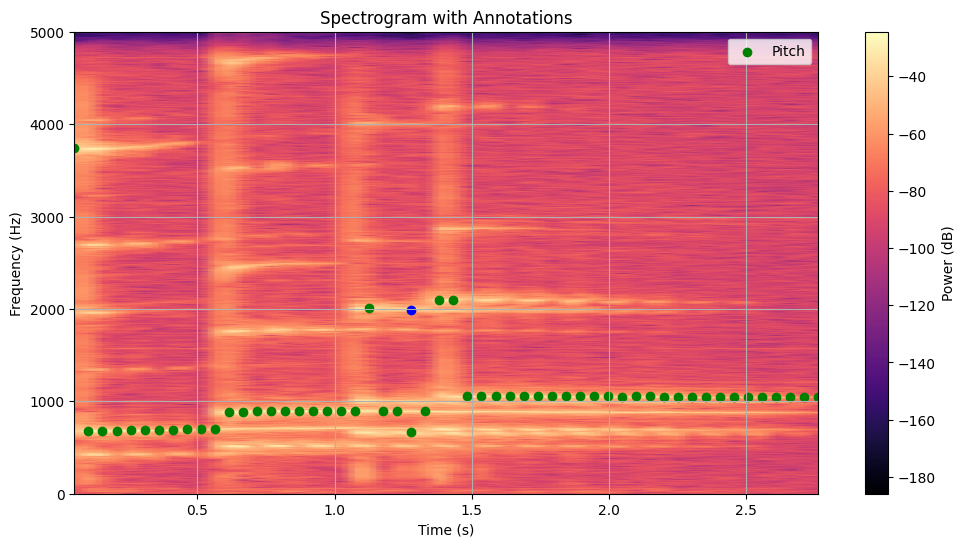

Calculating Manually......
	! . . Please Wait . . !
		.....It may take several seconds.....


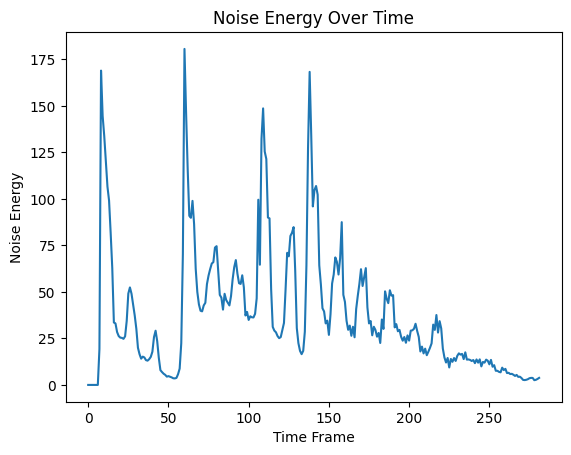

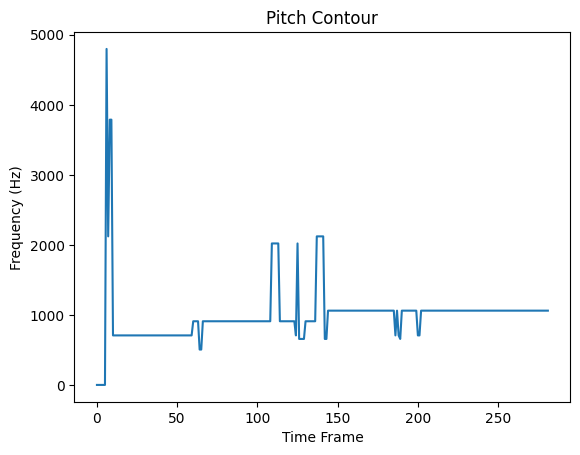

In [1]:
##############################################################
#                            Group: 01                       #
##############################################################

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import spectrogram
import librosa


def manual_dft(signal):
    """
    We are calculating DFT manually here.
    """
    N = len(signal)
    dft_result = []
    
    for k in range(N):
        real_part = 0
        imag_part = 0
        for n in range(N):
            angle = -2 * np.pi * k * n / N
            real_part += signal[n] * np.cos(angle)
            imag_part += signal[n] * np.sin(angle)
        dft_result.append(complex(real_part, imag_part))
    
    return np.array(dft_result)

def manual_fft(signal, fs, frame_size=0.02, overlap=0.5):
    """
    Analyze an audio signal using a manually implemented FFT.
    """
    frame_len = int(frame_size * fs)
    hop_size = int(frame_len * (1 - overlap))
    window = np.hanning(frame_len)

    pitch_contour = []
    harmonics_list = []
    noise_energy_list = []
    
    # Iterate through frames
    for start in range(0, len(signal) - frame_len, hop_size):
        frame = signal[start:start+frame_len] * window

        # Manual FFT Implementation
        dft_result = manual_dft(frame)
        magnitude_spectrum = np.abs(dft_result[:frame_len // 2])
        frequencies = np.linspace(0, fs / 2, frame_len // 2)

        # Step 1: Pitch Detection (Fundamental Frequency)
        peak_idx = np.argmax(magnitude_spectrum)
        f0 = frequencies[peak_idx]
        pitch_contour.append(f0)

        # Step 2: Harmonics Detection
        harmonics = []
        for n in range(2, 10):  # Checking up to 10 harmonics
            harmonic_freq = n * f0
            if harmonic_freq < frequencies[-1]:
                harmonic_idx = np.argmin(np.abs(frequencies - harmonic_freq))
                if magnitude_spectrum[harmonic_idx] > 0.1 * magnitude_spectrum[peak_idx]:  # Threshold
                    harmonics.append(harmonic_freq)
        harmonics_list.append(harmonics)

        # Step 3: Noise Estimation
        harmonic_energy = sum([magnitude_spectrum[np.argmin(np.abs(frequencies - h))] for h in harmonics])
        total_energy = sum(magnitude_spectrum)
        noise_energy = total_energy - harmonic_energy
        noise_energy_list.append(noise_energy)

    return pitch_contour, harmonics_list, noise_energy_list

def analyze_audio_with_spectrogram(audio_signal, sampling_rate, nfft=2048, window_size=1024, overlap=512):
    # Compute spectrogram
    frequencies, times, Sxx = spectrogram(
        audio_signal, fs=sampling_rate, nperseg=window_size, noverlap=overlap, nfft=nfft
    )
    
    results = []
    for i in range(len(times)):
        Sxx_frame = Sxx[:, i]
        
        # Detect pitch (frequency with max magnitude)
        peak_idx = np.argmax(Sxx_frame)
        pitch = frequencies[peak_idx]
        
        # Identify harmonics
        harmonics = []
        for n in range(2, 10):  # Check up to the 10th harmonic
            harmonic_freq = n * pitch
            idx = np.argmin(np.abs(frequencies - harmonic_freq))
            if Sxx_frame[idx] > 0.1 * np.max(Sxx_frame):
                harmonics.append(frequencies[idx])
        
        # Analyze noise (spectral flatness)
        geometric_mean = np.exp(np.mean(np.log(Sxx_frame + 1e-10)))  # Avoid log(0)
        arithmetic_mean = np.mean(Sxx_frame)
        spectral_flatness = geometric_mean / arithmetic_mean
        noise_present = spectral_flatness > 0.1  # True if noise-like
        
        results.append({
            'time': times[i],
            'pitch': pitch,
            'harmonics': harmonics,
            'noise': noise_present
        })
    
    # Visualization
    plt.figure(figsize=(12, 6))
    plt.pcolormesh(times, frequencies, 10 * np.log10(Sxx), shading='gouraud', cmap='magma')
    plt.colorbar(label='Power (dB)')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.title('Spectrogram with Annotations')
    plt.grid(True)

    for result in results:
        time = result['time']
        pitch = result['pitch']
        harmonics = result['harmonics']
        plt.scatter(time, pitch, color='green', label='Pitch' if time == results[0]['time'] else "")
        for harmonic in harmonics:
            plt.scatter(time, harmonic, color='blue', label='Harmonic' if time == results[0]['time'] else "")
    
    plt.legend()
    plt.show()


###################################################################################
############################ Main Code Start from Here ############################
###################################################################################

# audio_path = "full_song.wav"  # Give the audio file
audio_path = "pure_tone.wav"  # Give the audio file
# audio_path = "music.wav"  # Give the audio file

#Audio pre-processing with librosa library ## real-time feature can be added here
print("... Loading the Audio File (.wav) ...", end='')
audio_signal, sampling_rate = librosa.load(audio_path, sr=10000)
print('\tLoaded Successfully!\n\n')


print("Genereting Spectrogram using Built-in Functions\n\n")
analyze_audio_with_spectrogram(audio_signal, sampling_rate)



print("Calculating Manually......", "\t! . . Please Wait . . !", "\t\t.....It may take several seconds.....", sep='\n')
pitch_contour, harmonics_list, noise_energy_list = manual_fft(audio_signal, sampling_rate)


#Plotting from manual process
plt.figure()
plt.plot(noise_energy_list)
plt.title("Noise Energy Over Time")
plt.xlabel("Time Frame")
plt.ylabel("Noise Energy")
plt.show()

plt.figure()
plt.plot(pitch_contour)
plt.title("Pitch Contour")
plt.xlabel("Time Frame")
plt.ylabel("Frequency (Hz)")
plt.show()